In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [30]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [31]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
7319556,RIALTO,KING STREET,COLLINS STREET,FLINDERS LANE,2,1424E,06/05/2012 08:51:39 AM,06/05/2012 10:16:03 AM,5064,2P SUN 7:30-18:30,0,839,5043
13961,HARDWARE,LT BOURKE STREET,QUEEN STREET,ELIZABETH STREET,4,2553S,01/10/2011 01:59:43 PM,01/10/2011 02:28:21 PM,1718,1/2P MTR M-SAT 7:30-19:30,0,907,1295
1564520,REGENCY,LA TROBE STREET,EXHIBITION STREET,SPRING STREET,4,3627S,13/11/2011 05:47:45 PM,13/11/2011 06:30:00 PM,2535,2P SUN 7:30-18:30,0,856,2130
876284,QUEENSBERRY,ERROL STREET,QUEENSBERRY STREET,VICTORIA STREET,2,10166E,25/10/2011 04:32:41 PM,25/10/2011 04:48:36 PM,955,1P TKT A M-F 7:30-18:30,0,641,3027
11439312,SPENCER,BOURKE STREET,SPENCER STREET,KING STREET,4,2479S,07/09/2012 09:11:51 AM,07/09/2012 09:56:42 AM,2691,1P MTR M-SAT 7:30-19:30,0,123,7816


In [32]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [33]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [34]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 42
Maximum parking duration (seconds): 86260

Minimum parking duration (hour): 0.011666666666666667
Maximum parking duration (hour): 23.961111111111112


NameError: name 'math' is not defined

In [35]:

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
7319556,0,0,0,0,0,0,2,839,5043,8,10
13961,1,1,1,1,1,0,4,907,1295,13,14
1564520,2,2,2,2,0,0,4,856,2130,17,18
876284,3,3,3,3,2,0,2,641,3027,16,16
11439312,4,4,4,4,3,0,4,123,7816,9,9
9156330,5,5,5,3,4,0,2,1062,6798,9,10
8672567,6,1,6,5,5,0,4,907,5644,7,7
6973203,7,6,7,6,6,0,3,1278,4097,18,18
9592943,8,7,8,7,3,0,3,528,1245,10,11
12055777,9,8,0,0,7,0,2,627,552,19,19


In [36]:
#Parameter Tuning

#Define the parameters to tune and the values to tune to
params_randomforest = [
                { 
                   'n_estimators' : (10,20,30,50,70,90,100),
                    'criterion' : ('gini', 'entropy'),
                    'max_depth' : (3, 5, 7, 9, 10, 15),
                    'max_features' : ('auto', 'sqrt'),
                    'min_samples_split' : (2, 4, 6, 8, 10, 14, 16)
                    
                }
            ]

In [37]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_randomforest = GridSearchCV(RandomForestClassifier(), 
                      param_grid = params_randomforest, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [38]:
#Fit the model with the dataset
bestModel = gs_randomforest.fit(features, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  4.3min finished


In [39]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 10}

In [40]:
#Find the best values for the  parameters of the model (Formatted output)
best_e = bestModel.best_estimator_.get_params()['n_estimators']
best_C = bestModel.best_estimator_.get_params()['criterion']
best_maxd =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf =  bestModel.best_estimator_.get_params()['max_features']
best_mins =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimator:', best_e)
print('Best criterion:', best_C)
print('Best max depth:', best_maxd)
print('Best max features:', best_maxf)
print('Best min_samples_split:', best_mins)

Best estimator: 10
Best criterion: entropy
Best max depth: 3
Best max features: auto
Best min_samples_split: 2


In [41]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8564
1,gini,3,auto,2,20,0.8564
2,gini,3,auto,2,30,0.8563
3,gini,3,auto,2,50,0.8562
4,gini,3,auto,2,70,0.8564
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8562
1172,entropy,15,sqrt,16,50,0.8560
1173,entropy,15,sqrt,16,70,0.8560
1174,entropy,15,sqrt,16,90,0.8562


In [44]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
randomforest = metric = RandomForestClassifier(n_estimators = best_e, 
                               criterion = best_C, 
                               max_depth = best_maxd, 
                               max_features = best_maxf,
                               min_samples_split = best_mins                
                               )

In [46]:
# Hill climbing w/ SVM
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = randomforest.fit(x_train, y_train)
    cur_Score = randomforest.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.861
Score with 2 selected features: 0.861
Score with 3 selected features: 0.861
Score with 4 selected features: 0.861
Score with 5 selected features: 0.861
Score with 6 selected features: 0.861
Score with 7 selected features: 0.861
Score with 8 selected features: 0.861
Score with 9 selected features: 0.861
Score with 10 selected features: 0.861
Score with 11 selected features: 0.861

Indexs of the desired features
[2, 3, 4, 9, 1, 6, 0, 7, 10, 8, 5]


In [47]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Between Street 2,Sign,Arrival Hour,Street Name,Side Of Street,Area Name,Street ID,Departure Hour,Device ID,In Violation?
7319556,0,0,0,8,0,2,0,839,10,5043,0
13961,1,1,1,13,1,4,1,907,14,1295,0
1564520,2,2,0,17,2,4,2,856,18,2130,0
876284,3,3,2,16,3,2,3,641,16,3027,0
11439312,4,4,3,9,4,4,4,123,9,7816,0
9156330,5,3,4,9,5,2,5,1062,10,6798,0
8672567,6,5,5,7,1,4,6,907,7,5644,0
6973203,7,6,6,18,6,3,7,1278,18,4097,0
9592943,8,7,3,10,7,3,8,528,11,1245,0
12055777,0,0,7,19,8,2,9,627,19,552,0


In [48]:
bestModel = gs_randomforest.fit(features_hc, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  4.3min finished


In [49]:
gs_randomforest.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 20}

In [50]:
best_e_hc = bestModel.best_estimator_.get_params()['n_estimators']
best_C_hc = bestModel.best_estimator_.get_params()['criterion']
best_maxd_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf_hc =  bestModel.best_estimator_.get_params()['max_features']
best_mins_hc =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimators:', best_e_hc)
print('Best criterion:', best_C_hc)
print('Best max depth:', best_maxd_hc)
print('Best max features:', best_maxf_hc)
print('Best min_samples_split:', best_mins_hc)

Best estimators: 20
Best criterion: gini
Best max depth: 3
Best max features: auto
Best min_samples_split: 2


In [51]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8563
1,gini,3,auto,2,20,0.8564
2,gini,3,auto,2,30,0.8563
3,gini,3,auto,2,50,0.8564
4,gini,3,auto,2,70,0.8564
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.8561
1172,entropy,15,sqrt,16,50,0.8562
1173,entropy,15,sqrt,16,70,0.8562
1174,entropy,15,sqrt,16,90,0.8561


In [52]:
randomforest = metric = RandomForestClassifier(n_estimators = best_e_hc, 
                               criterion = best_C_hc, 
                               max_depth = best_maxd_hc, 
                               max_features = best_maxf_hc,
                               min_samples_split = best_mins_hc                
                               )


 Accuracy score: 0.85460

 Misclassification Rate: 0.14540

 True Positive Rate: 0.00000

 True Negative Rate: 0.99977

 Precision : 0.00000

 Prevalence : 0.14520

 F score : nan

 False Positive Rate: 0.00023


<ipython-input-53-2c5ce7faf1a9>:39: RuntimeWarning: invalid value encountered in double_scalars
  fscore = (2 * precision * sensitivity) / (precision + sensitivity)


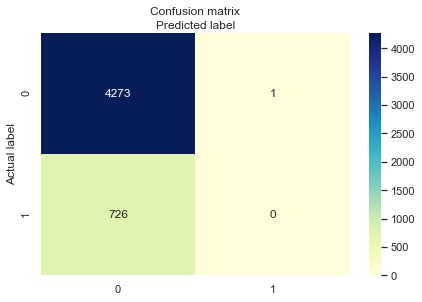

In [53]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
randomforest.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = randomforest.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(randomforest.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

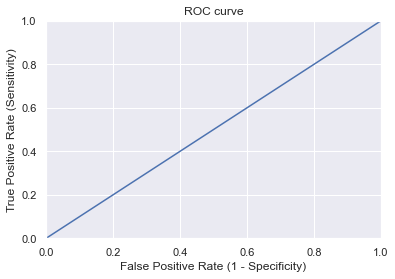

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [55]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    randomforest.fit(x_train, y_train)
    kFoldTotal += randomforest.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, randomforest.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.84800
[fold 1] score: 0.85350
[fold 2] score: 0.86600
[fold 3] score: 0.84850
[fold 4] score: 0.86550

KNN mean score [5 folds] = 0.8563
